# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 
## Gonzalo Blazquez

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [88]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [89]:
# Add any additional import statements you need here
# nltk.download('stopwords')

import csv
csv.field_size_limit(10**6) # for big twitter descriptions
import matplotlib.pyplot as plt

In [90]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/Gonzalo B/Downloads/AppliedTextMining/Module2/Assign 2/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [92]:
def descriptive_stats(tokens, top_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)

    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(top_tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The five most common tokens in the data:")
        for token, count in most_common_tokens:
            print(f"{token}: {count}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [93]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The five most common tokens in the data:
text: 3
here: 2
example: 2
is: 1
some: 1


Q: Why is it beneficial to use assertion statements in your code? 

A: Using assertion is benefical because it helps to check if the output of a function in this example is behaving the way it is supposed to. If the condition is false it will raise an assertion error, indicating a problem in the code.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [95]:
# Read in the lyrics data
lyrics_data = {}
songs_titles = {} # for song titles question
for artist_folder in os.listdir(os.path.join(data_location, lyrics_folder)):
    #
    artist_path=os.path.join(data_location, lyrics_folder,artist_folder)
    #
    lyrics_data[artist_folder] = {}
    song_title_list=[]
    # Get song path and name
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        song_name = song_file.split('_', 1)[1].replace('.txt', '')

        # From each file get the song title and the lyrics
        with open(song_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            lyrics = ''.join(lines[4:]).strip()
            song_title = lines[0].strip().strip('"')
        song_title_list.append(song_title)
        lyrics_data[artist_folder][song_name] = lyrics
    songs_titles[artist_folder] = song_title_list

In [96]:
# Read in the twitter data
artist_descriptions = {}

for artist_file in os.listdir(os.path.join(data_location, twitter_folder)):
        if artist_file.endswith('.txt'):
                description_path=os.path.join(data_location, twitter_folder, artist_file)
                artist = artist_file.split('_', 1)[0]
                # Read each file as a table to get the values of the description column
                with open(description_path, mode='r', encoding='utf-8') as file:
                        reader = csv.DictReader(file, delimiter='\t')  
                        for row in reader:
                                description = row['description'] 
                                # Only if it has a description it will add it
                                if description:
                                        if artist in artist_descriptions:
                                                artist_descriptions[artist].append(description)
                                        else:
                                                artist_descriptions[artist] = [description]
                                

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [97]:
punctuation = set(punctuation) - {'#'} # Keep # for its question
stopwords= set(sw)

def clean_and_tokenize(text):
    # Lowercase
    text = text.lower()
    # Punctuation
    text = ''.join(char for char in text if char not in punctuation)
    # Split
    tokens = text.split()
    # Stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    return tokens

In [98]:
# create your clean twitter data here
cleaned_artist_descriptions = {}
for artist, descriptions in artist_descriptions.items():
    # list for cleaned tokens
    cleaned_tokens_list = []
    
    for description in descriptions:
        # Clean and tokenize each description
        cleaned_tokens = clean_and_tokenize(description)
        cleaned_tokens_list.extend(cleaned_tokens)
    cleaned_artist_descriptions[artist] = cleaned_tokens_list

In [99]:
# create your clean lyrics data here
cleaned_artist_lyrics = {}
for artist, songs in lyrics_data.items():
    # list for cleaned tokens
    cleaned_tokens_list = []
    
    for song, lyrics in songs.items():
        # Clean and tokenize each description
        cleaned_tokens = clean_and_tokenize(lyrics)
        cleaned_tokens_list.extend(cleaned_tokens)
    cleaned_artist_lyrics[artist] = cleaned_tokens_list

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [100]:
# calls to descriptive_stats here
descriptive_stats(cleaned_artist_lyrics["cher"], verbose=True)

There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
The five most common tokens in the data:
love: 966
im: 511
know: 480
dont: 430
youre: 332


[35233, 3684, 0.10456106491073709, 169244]

In [101]:
descriptive_stats(cleaned_artist_lyrics["robyn"], verbose=True)

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
The five most common tokens in the data:
know: 305
im: 299
dont: 297
love: 269
got: 249


[15041, 2139, 0.1422112891430091, 72804]

In [102]:
descriptive_stats(cleaned_artist_descriptions["cher"], verbose=True)

There are 16192727 tokens in the data.
There are 1746381 unique tokens in the data.
There are 96734590 characters in the data.
The lexical diversity is 0.108 in the data.
The five most common tokens in the data:
love: 213656
im: 139100
life: 122714
music: 86800
de: 73361


[16192727, 1746381, 0.10784971549264062, 96734590]

In [103]:
descriptive_stats(cleaned_artist_descriptions["robynkonichiwa"], verbose=True)

There are 1538430 tokens in the data.
There are 277006 unique tokens in the data.
There are 9427994 characters in the data.
The lexical diversity is 0.180 in the data.
The five most common tokens in the data:
music: 14871
love: 11621
im: 9050
och: 7922
life: 7358


[1538430, 277006, 0.1800575911806192, 9427994]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: Probaly all of the top 5 words would be stopwords if we left them in the data. This is because they tend to be repeated a lot.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I didn't know Robyn, but I would though that Cher has a low lexical diversity seens her music tends to focus on other things rather than words, like melody. This is sort of confirmed by the results since Robyn has 0.142 lexical diversity and Cher has 0.105.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [104]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [105]:
# Cher emojis
emoji_counter = Counter()
    
for token in cleaned_artist_descriptions["cher"]:
    if emoji.is_emoji(token):
        emoji_counter[token] += 1
emoji_counter.most_common(10)

[('❤️', 14741),
 ('🏳️\u200d🌈', 14190),
 ('♥', 10251),
 ('❤', 9690),
 ('✨', 8422),
 ('🌈', 5497),
 ('🇺🇸', 3742),
 ('💙', 3708),
 ('💜', 3512),
 ('🌊', 3292)]

In [106]:
# Robyn emojis
emoji_counter = Counter()
    
for token in cleaned_artist_descriptions["robynkonichiwa"]:
    if emoji.is_emoji(token):
        emoji_counter[token] += 1
emoji_counter.most_common(10)

[('🏳️\u200d🌈', 1708),
 ('♥', 1170),
 ('❤️', 991),
 ('✨', 755),
 ('❤', 655),
 ('🌈', 572),
 ('🎶', 272),
 ('🎧', 214),
 ('🖤', 212),
 ('💜', 206)]

### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [107]:
# Cher Hashtags
hashtag_counter = Counter()
    
for token in cleaned_artist_descriptions["cher"]:
    if token.startswith("#"):
        hashtag_counter[token] += 1
hashtag_counter.most_common(10)

[('#resist', 10540),
 ('#blm', 9588),
 ('#blacklivesmatter', 7777),
 ('#theresistance', 3211),
 ('#fbr', 3131),
 ('#resistance', 2787),
 ('#1', 2428),
 ('#', 2140),
 ('#voteblue', 2062),
 ('#lgbtq', 1791)]

In [108]:
# Robyn Hashtags
hashtag_counter = Counter()
    
for token in cleaned_artist_descriptions["robynkonichiwa"]:
    if token.startswith("#"):
        hashtag_counter[token] += 1
hashtag_counter.most_common(10)

[('#blacklivesmatter', 584),
 ('#blm', 341),
 ('#music', 289),
 ('#1', 194),
 ('#', 169),
 ('#teamfollowback', 127),
 ('#edm', 108),
 ('#lgbtq', 81),
 ('#resist', 80),
 ('#art', 69)]

### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [109]:
# Here is used the song titles recoleted at the beginning
cleaned_artist_titles = {}
cleaned_tokens_list = []

for title in songs_titles["cher"]:
        # Clean and tokenize each description
        cleaned_tokens = clean_and_tokenize(title)
        cleaned_tokens_list.extend(cleaned_tokens)
        cleaned_artist_titles = cleaned_tokens_list

artist_common_words = {}
word_counts = Counter(cleaned_artist_titles)
common_words = word_counts.most_common(5)
common_words

[('love', 38), ('man', 12), ('song', 11), ('dont', 10), ('come', 7)]

In [110]:
cleaned_artist_titles = {}
cleaned_tokens_list = []

for title in songs_titles["robyn"]:
        # Clean and tokenize each description
        cleaned_tokens = clean_and_tokenize(title)
        cleaned_tokens_list.extend(cleaned_tokens)
        cleaned_artist_titles = cleaned_tokens_list

artist_common_words = {}
word_counts = Counter(cleaned_artist_titles)
common_words = word_counts.most_common(5)
common_words

[('love', 6), ('dont', 4), ('u', 4), ('thing', 3), ('girl', 3)]

### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

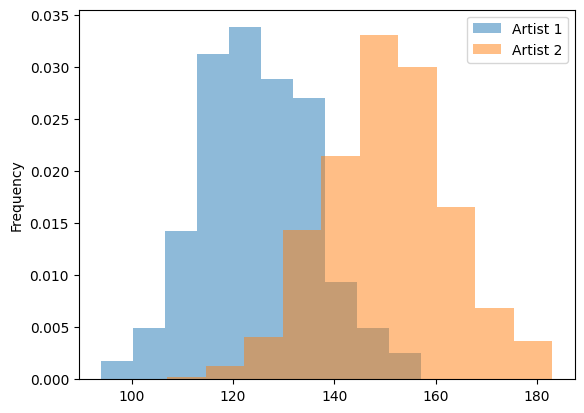

In [111]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The regular expression matches one or more whitespaces.


In [112]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

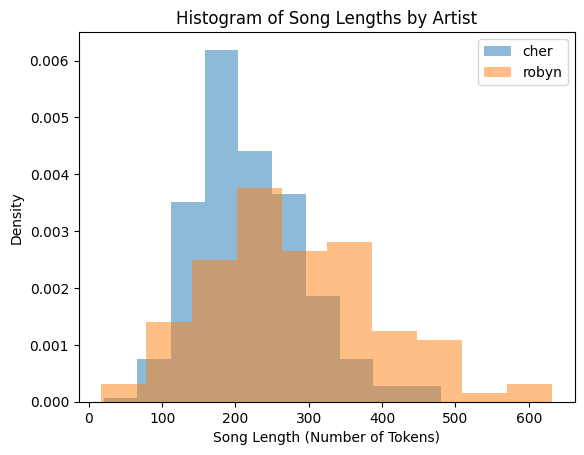

In [113]:
# Your lyric length comparison chart here. 
song_lengths = []
# Iterate over the lyrics data and tokenize lyrics
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        tokens = tokenize_lyrics(lyrics)
        length = len(tokens)
        song_lengths.append({"artist": artist, "song": song, "length": length})

df = pd.DataFrame(song_lengths)

# Plot
df.groupby('artist')['length'].plot(kind="hist", density=True, alpha=0.5, legend=True)
plt.xlabel("Song Length (Number of Tokens)")
plt.ylabel("Density")
plt.title("Histogram of Song Lengths by Artist")
plt.show()